#Classification of Water Consumption Types

[Assignment SI - Infos](https://drive.google.com/file/d/1lh5a0YxVsC-NXtsIpucTVCrfJR_8KZB4/view?usp=sharing)

[Dataset Train](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/train.csv)

[Dataset Competition](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/competition.csv)

### 1) **IMPORT** and **UTILITY**

Import all usefull libraries and define some usefull functions

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

### 2) **READ DATA FILES**

Read data file uploaded to this google colab

In [2]:
train = pd.read_csv("train_without_outliers_v2.csv")

In [3]:
train.shape

(271467, 6)

In [4]:
train.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,domestic,0,MOGV36480546611521,Installation_zone 1
1,2013,1,domestic,6,VRFW65577141436242,Installation_zone 2
2,2013,1,domestic,1,QLLI18662653137621,Installation_zone 2
3,2013,1,domestic,13,HYUO61823402850645,Installation_zone 2
4,2013,1,industrial,5,APVF78863215212358,Installation_zone 2


In [5]:
train.info

<bound method DataFrame.info of         Year  Month     Consumer_type  Consumption     Consumer_number  \
0       2013      1          domestic            0  MOGV36480546611521   
1       2013      1          domestic            6  VRFW65577141436242   
2       2013      1          domestic            1  QLLI18662653137621   
3       2013      1          domestic           13  HYUO61823402850645   
4       2013      1        industrial            5  APVF78863215212358   
...      ...    ...               ...          ...                 ...   
271462  2020     12    rural domestic            0  ZUSP24367270097432   
271463  2020     12        industrial            1  DSHL10873458082274   
271464  2020     12        industrial            0  FBGR74791990429444   
271465  2020     12          domestic            2  YFOH47364653857327   
271466  2020     12  rural commercial            0  BDFY81359894468146   

           Installation_zone  
0        Installation_zone 1  
1        Installa

In [6]:
print(train['Consumer_type'].unique())

['domestic' 'industrial' 'rural commercial' 'low income families'
 'construction' 'rural domestic' 'rural expansion']


In [7]:
domestic_qtd = train['Consumer_type'].value_counts()['domestic']
print(domestic_qtd)

203909


 ### 3) **Pre Processing**

   

In [8]:
le_ct = LabelEncoder()
le_ct.fit(train['Consumer_type'].unique())

le_iz = LabelEncoder()
le_iz.fit(train['Installation_zone'].unique())

le_cn = LabelEncoder()
le_cn.fit(train['Consumer_number'].unique())

train_le = train

train_le['Consumer_type'] = le_ct.transform(train['Consumer_type'])
train_le['Installation_zone'] = le_iz.transform(train['Installation_zone'])
train_le['Consumer_number'] = le_cn.transform(train['Consumer_number'])

# le_ct.classes_
# print(le_ct.inverse_transform([0, 1, 2, 3, 4, 5, 6]))
# print(le_iz.classes_)
# print(train_le['Installation_zone'].unique())

In [9]:
train.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,1,0,7330,0
1,2013,1,1,6,12572,11
2,2013,1,1,1,9585,11
3,2013,1,1,13,4643,11
4,2013,1,2,5,396,11


In [10]:
train_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271467 entries, 0 to 271466
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Year               271467 non-null  int64
 1   Month              271467 non-null  int64
 2   Consumer_type      271467 non-null  int64
 3   Consumption        271467 non-null  int64
 4   Consumer_number    271467 non-null  int64
 5   Installation_zone  271467 non-null  int64
dtypes: int64(6)
memory usage: 12.4 MB


In [11]:
scaler = MinMaxScaler()

industrial_df = train_le[train_le['Consumer_type'] == 2]
industrial_df = industrial_df.drop('Consumer_type', axis=1)
industrial_train_mms = pd.DataFrame(scaler.fit_transform(industrial_df.values), index=industrial_df.index, columns=industrial_df.columns)

rural_commercial_df = train_le[train_le['Consumer_type'] == 4]
rural_commercial_df = rural_commercial_df.drop('Consumer_type', axis=1)
rural_commercial_train_mms = pd.DataFrame(scaler.fit_transform(rural_commercial_df.values), index=rural_commercial_df.index, columns=rural_commercial_df.columns)

construction_df = train_le[train_le['Consumer_type'] == 0]
construction_df = construction_df.drop('Consumer_type', axis=1)
construction_train_mms = pd.DataFrame(scaler.fit_transform(construction_df.values), index=construction_df.index, columns=construction_df.columns)

low_income_families_df = train_le[train_le['Consumer_type'] == 3]
low_income_families_df = low_income_families_df.drop('Consumer_type', axis=1)
low_income_families_train_mms = pd.DataFrame(scaler.fit_transform(low_income_families_df.values), index=low_income_families_df.index, columns=low_income_families_df.columns)

rural_domestic_df = train_le[train_le['Consumer_type'] == 5]
rural_domestic_df = rural_domestic_df.drop('Consumer_type', axis=1)
rural_domestic_train_mms = pd.DataFrame(scaler.fit_transform(rural_domestic_df.values), index=rural_domestic_df.index, columns=rural_domestic_df.columns)

rural_expansion_df = train_le[train_le['Consumer_type'] == 6]
rural_expansion_df = rural_expansion_df.drop('Consumer_type', axis=1)
rural_expansion_train_mms = pd.DataFrame(scaler.fit_transform(rural_expansion_df.values), index=rural_expansion_df.index, columns=rural_expansion_df.columns)

In [12]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf

In [13]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1
Found GPU at: /device:GPU:0


In [14]:
tf.get_logger().setLevel(logging.ERROR)


class Gan():

    def __init__(self, data):

        self.data = data
        self.n_epochs = 1500

    # Genereta random noise in a latent space
    def _noise(self):
        noise = np.random.rand(self.data.shape[0], self.data.shape[1])
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        G_losses = []
        D_losses = []

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):

            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))

            G_losses.append(g_loss)
            D_losses.append(d_loss)

            print('>%d, D = %f, G = %f' %(epoch+1, d_loss, g_loss))

        return generator, G_losses, D_losses

532/532 [==============================] - 2s 2ms/step
>1, D = 0.752684, G = 0.698716
532/532 [==============================] - 2s 3ms/step
>2, D = 0.731200, G = 0.696090
532/532 [==============================] - 1s 1ms/step
>3, D = 0.710137, G = 0.692322
532/532 [==============================] - 1s 1ms/step
>4, D = 0.690091, G = 0.688795
532/532 [==============================] - 1s 1ms/step
>5, D = 0.669991, G = 0.685560
532/532 [==============================] - 1s 1ms/step
>6, D = 0.651123, G = 0.681697
532/532 [==============================] - 1s 1ms/step
>7, D = 0.631890, G = 0.678486
532/532 [==============================] - 1s 2ms/step
>8, D = 0.614561, G = 0.673714
532/532 [==============================] - 1s 2ms/step
>9, D = 0.596571, G = 0.670045
532/532 [==============================] - 1s 1ms/step
>10, D = 0.579965, G = 0.665260
532/532 [==============================] - 1s 1ms/step
>11, D = 0.563133, G = 0.659760
532/532 [==============================] - 1s 1ms/st

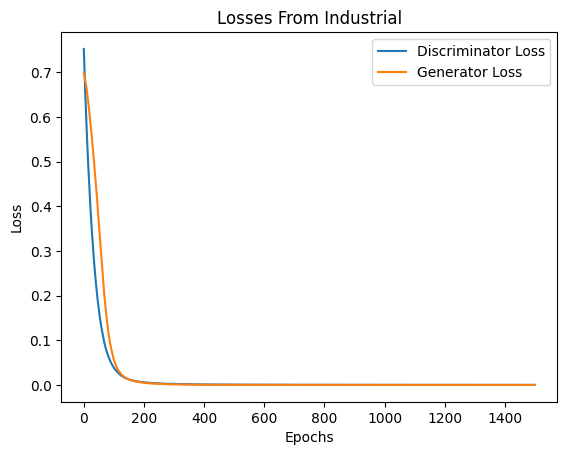

In [15]:
G = Gan(industrial_train_mms)
gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

industrial_generated = gen.predict(np.random.rand((domestic_qtd - industrial_train_mms.shape[0]), industrial_train_mms.shape[1]))

plt.title('Losses From Industrial')
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

124/124 [==============================] - 0s 2ms/step
>1, D = 0.724901, G = 0.503013
124/124 [==============================] - 0s 1ms/step
>2, D = 0.711166, G = 0.492547
124/124 [==============================] - 0s 1ms/step
>3, D = 0.697723, G = 0.484879
124/124 [==============================] - 0s 1ms/step
>4, D = 0.686387, G = 0.469863
124/124 [==============================] - 0s 1ms/step
>5, D = 0.673497, G = 0.461670
124/124 [==============================] - 0s 1ms/step
>6, D = 0.661308, G = 0.449716
124/124 [==============================] - 0s 1ms/step
>7, D = 0.649059, G = 0.440428
124/124 [==============================] - 0s 1ms/step
>8, D = 0.636784, G = 0.431351
124/124 [==============================] - 0s 1ms/step
>9, D = 0.625814, G = 0.418472
124/124 [==============================] - 0s 1ms/step
>10, D = 0.613930, G = 0.408328
124/124 [==============================] - 0s 1ms/step
>11, D = 0.602637, G = 0.396483
124/124 [==============================] - 0s 1ms/st

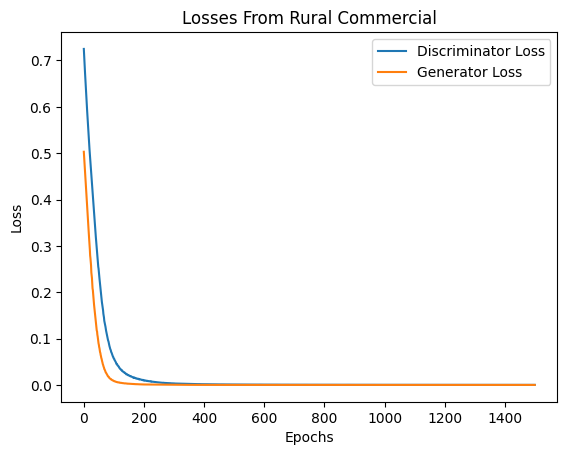

In [16]:
G = Gan(rural_commercial_train_mms)
gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

rural_commercial_generated = gen.predict(np.random.rand((domestic_qtd - rural_commercial_train_mms.shape[0]), rural_commercial_train_mms.shape[1]))

plt.title('Losses From Rural Commercial')
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

41/41 [==============================] - 0s 1ms/step
>1, D = 1178.018433, G = 0.725030
41/41 [==============================] - 0s 1ms/step
>2, D = 1054.659058, G = 0.717499
41/41 [==============================] - 0s 2ms/step
>3, D = 933.380310, G = 0.708192
41/41 [==============================] - 0s 2ms/step
>4, D = 813.634766, G = 0.701187
41/41 [==============================] - 0s 1ms/step
>5, D = 695.591919, G = 0.690824
41/41 [==============================] - 0s 1ms/step
>6, D = 577.947266, G = 0.685898
41/41 [==============================] - 0s 2ms/step
>7, D = 460.560852, G = 0.675839
41/41 [==============================] - 0s 1ms/step
>8, D = 345.764740, G = 0.665788
41/41 [==============================] - 0s 2ms/step
>9, D = 232.724487, G = 0.658116
41/41 [==============================] - 0s 2ms/step
>10, D = 126.632767, G = 0.650418
41/41 [==============================] - 0s 2ms/step
>11, D = 37.796665, G = 0.643193
41/41 [==============================] - 0s 2ms/ste

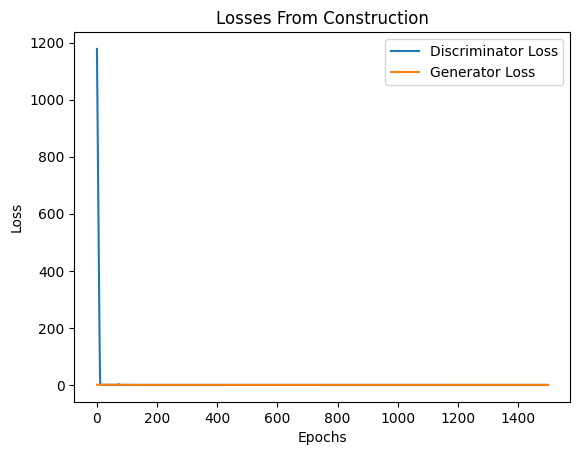

In [17]:
G = Gan(construction_df)
gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

construction_generated = gen.predict(np.random.rand((domestic_qtd - construction_df.shape[0]), construction_df.shape[1]))

plt.title('Losses From Construction')
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
G = Gan(low_income_families_df)
gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

low_income_families_generated = gen.predict(np.random.rand((domestic_qtd - low_income_families_df.shape[0]), low_income_families_df.shape[1]))

plt.title('Losses From Low Income Families')
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 0s 3ms/step
>1, D = 0.696706, G = 0.728023
16/16 [==============================] - 0s 2ms/step
>2, D = 0.669965, G = 0.721063
16/16 [==============================] - 0s 2ms/step
>3, D = 0.654598, G = 0.715794
16/16 [==============================] - 0s 2ms/step
>4, D = 0.637152, G = 0.711678
16/16 [==============================] - 0s 2ms/step
>5, D = 0.613391, G = 0.708644
16/16 [==============================] - 0s 2ms/step
>6, D = 0.593206, G = 0.705439
16/16 [==============================] - 0s 2ms/step
>7, D = 0.579574, G = 0.702218
16/16 [==============================] - 0s 2ms/step
>8, D = 0.557884, G = 0.698930
16/16 [==============================] - 0s 2ms/step
>9, D = 0.536231, G = 0.697233
16/16 [==============================] - 0s 2ms/step
>10, D = 0.514430, G = 0.696647
16/16 [==============================] - 0s 2ms/step
>11, D = 0.502631, G = 0.695186
16/16 [==============================] - 0s 1ms/step
>12, D = 0.484019, G 

In [ ]:
G = Gan(rural_domestic_df)
gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

rural_domestic_generated = gen.predict(np.random.rand((domestic_qtd - rural_domestic_df.shape[0]), rural_domestic_df.shape[1]))

plt.title('Losses From Rural Domestic')
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1378/1378 [==============================] - 2s 1ms/step
>1, D = 0.389996, G = 0.645448
1378/1378 [==============================] - 2s 2ms/step
>2, D = 0.381213, G = 0.641667
1378/1378 [==============================] - 2s 2ms/step
>3, D = 0.383986, G = 0.637498
1378/1378 [==============================] - 2s 1ms/step
>4, D = 0.369467, G = 0.634381
1378/1378 [==============================] - 2s 1ms/step
>5, D = 0.365005, G = 0.630767
1378/1378 [==============================] - 2s 2ms/step
>6, D = 0.360496, G = 0.627220
1378/1378 [==============================] - 2s 1ms/step
>7, D = 0.355753, G = 0.623872
1378/1378 [==============================] - 2s 1ms/step
>8, D = 0.351069, G = 0.620915
1378/1378 [==============================] - 2s 1ms/step
>9, D = 0.346221, G = 0.617975
1378/1378 [==============================] - 2s 2ms/step
>10, D = 0.341432, G = 0.614750
1378/1378 [==============================] - 2s 1ms/step
>11, D = 0.336604, G = 0.612256
1378/1378 [===================

In [ ]:
G = Gan(rural_expansion_df)
gen, G_losses, D_losses = G.train(G._generator(), G._discriminator(), G._GAN(G._generator(), G._discriminator()))

rural_expansion_generated = gen.predict(np.random.rand((domestic_qtd - rural_expansion_df.shape[0]), rural_expansion_df.shape[1]))

plt.title('Losses From Rural Expansion')
plt.plot(range(len(D_losses)), D_losses, label='Discriminator Loss')
plt.plot(range(len(G_losses)), G_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
industrial_generated_df = pd.DataFrame(scaler.inverse_transform(industrial_generated), columns=industrial_train_mms.columns)
industrial_generated_df['Consumer_type'] = 2

rural_commercial_generated_df = pd.DataFrame(scaler.inverse_transform(rural_commercial_generated), columns=rural_commercial_train_mms.columns)
rural_commercial_generated_df['Consumer_type'] = 4

construction_generated_df = pd.DataFrame(scaler.inverse_transform(construction_generated), columns=construction_df.columns)
construction_generated_df['Consumer_type'] = 0

low_income_families_generated_df = pd.DataFrame(scaler.inverse_transform(low_income_families_generated), columns=low_income_families_df.columns)
low_income_families_generated_df['Consumer_type'] = 3

rural_domestic_generated_df = pd.DataFrame(scaler.inverse_transform(rural_domestic_generated), columns=rural_domestic_df.columns)
rural_domestic_generated_df['Consumer_type'] = 5

rural_expansion_generated_df = pd.DataFrame(scaler.inverse_transform(rural_expansion_generated), columns=rural_expansion_df.columns)
rural_expansion_generated_df['Consumer_type'] = 6

generated_df = pd.concat([industrial_generated_df, rural_commercial_generated_df, construction_generated_df, low_income_families_generated_df, rural_domestic_generated_df, rural_expansion_generated_df], axis=0)
generated_df = generated_df.astype('int16').abs()

In [ ]:
generated_df.head()

In [ ]:
generated_df['Consumer_type'] = le_ct.inverse_transform(generated_df['Consumer_type'])

generated_df = generated_df[generated_df['Installation_zone'].isin(le_iz.transform(le_iz.classes_))]
generated_df['Installation_zone'] = le_iz.inverse_transform(generated_df['Installation_zone'])

generated_df_with_new_consumer_numbers = generated_df[~generated_df['Consumer_number'].isin(le_cn.classes_)]

generated_df = generated_df[generated_df['Consumer_number'].isin(le_cn.classes_)]
generated_df['Consumer_number'] = le_cn.inverse_transform(generated_df['Consumer_number'])

In [ ]:
generated_df.head()

In [ ]:
generated_df_with_new_consumer_numbers.head()

In [ ]:
generated_df.shape

In [ ]:
generated_df_with_new_consumer_numbers.shape

In [ ]:
import random
import string

def generate_consumer_number(consumer_number):
    random_part_1 = ''.join(random.choices(string.ascii_uppercase, k=4))
    random_part_2 = ''.join(random.choices(string.digits, k=16))
    consumer_number = random_part_1 + random_part_2
    return consumer_number

In [ ]:
generated_df_with_new_consumer_numbers['Consumer_number'] = generated_df_with_new_consumer_numbers['Consumer_number'].apply(generate_consumer_number)

In [ ]:
generated_df_with_new_consumer_numbers.head()

In [ ]:
train = pd.read_csv("train.csv")

new_train = pd.concat([train, generated_df_with_new_consumer_numbers, generated_df], axis=0)

In [ ]:
new_train.head()

In [ ]:
new_train.shape

In [ ]:
# new_train.to_csv('new_train_v1.csv', sep=',', index=False)

In [ ]:
train = pd.read_csv("train.csv")
new_train = pd.read_csv("new_train_v1.csv")

train.shape

In [ ]:
new_train.shape

In [ ]:
print(train['Consumer_type'].unique())

print(train['Consumer_type'].value_counts()['domestic'])
print(train['Consumer_type'].value_counts()['industrial'])
print(train['Consumer_type'].value_counts()['rural commercial'])
print(train['Consumer_type'].value_counts()['construction'])
print(train['Consumer_type'].value_counts()['low income families'])
print(train['Consumer_type'].value_counts()['rural domestic'])
print(train['Consumer_type'].value_counts()['rural expansion'])

In [ ]:
print(new_train['Consumer_type'].unique())

print(new_train['Consumer_type'].value_counts()['domestic'])
print(new_train['Consumer_type'].value_counts()['industrial'])
print(new_train['Consumer_type'].value_counts()['rural commercial'])
print(new_train['Consumer_type'].value_counts()['construction'])
print(new_train['Consumer_type'].value_counts()['low income families'])
print(new_train['Consumer_type'].value_counts()['rural domestic'])
print(new_train['Consumer_type'].value_counts()['rural expansion'])

In [ ]:
test_1 = train[train['Consumer_type'] == 'domestic'].head(500)
test_2 = train[train['Consumer_type'] == 'industrial'].head(500)
test_3 = train[train['Consumer_type'] == 'rural commercial'].head(500)
test_4 = train[train['Consumer_type'] == 'construction'].head(500)
test_5 = train[train['Consumer_type'] == 'low income families'].head(500)
test_6 = train[train['Consumer_type'] == 'rural domestic'].head(500)
test_7 = train[train['Consumer_type'] == 'rural expansion'].head(500)

test = pd.concat([test_1, test_2, test_3, test_4, test_5, test_6, test_7], axis=0)

In [ ]:
test.shape

In [ ]:
# Merge DataFrames and identify the rows that are equal
merged_df = pd.merge(test, new_train, how='inner', indicator=True)

# Count the number of rows that are equal
num_equal_rows = len(merged_df[merged_df['_merge'] == 'both'])

print(num_equal_rows)

In [ ]:
# Merge DataFrames and identify the rows present in both
merged_df = pd.merge(new_train, test, how='outer', indicator=True)

# Filter out rows that exist in the second DataFrame
new_train = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [ ]:
# Merge DataFrames and identify the rows that are equal
merged_df = pd.merge(test, new_train, how='inner', indicator=True)

# Count the number of rows that are equal
num_equal_rows = len(merged_df[merged_df['_merge'] == 'both'])

print(num_equal_rows)

In [ ]:
new_train.shape

In [ ]:
test.shape

In [ ]:
print(new_train['Consumer_type'].unique())

print(new_train['Consumer_type'].value_counts()['domestic'])
print(new_train['Consumer_type'].value_counts()['industrial'])
print(new_train['Consumer_type'].value_counts()['rural commercial'])
print(new_train['Consumer_type'].value_counts()['construction'])
print(new_train['Consumer_type'].value_counts()['low income families'])
print(new_train['Consumer_type'].value_counts()['rural domestic'])
print(new_train['Consumer_type'].value_counts()['rural expansion'])

In [ ]:
print(test['Consumer_type'].unique())

print(test['Consumer_type'].value_counts()['domestic'])
print(test['Consumer_type'].value_counts()['industrial'])
print(test['Consumer_type'].value_counts()['rural commercial'])
print(test['Consumer_type'].value_counts()['construction'])
print(test['Consumer_type'].value_counts()['low income families'])
print(test['Consumer_type'].value_counts()['rural domestic'])
print(test['Consumer_type'].value_counts()['rural expansion'])

In [ ]:
new_train = new_train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

new_train.to_csv('new_train_v3.csv', sep=',', index=False)
test.to_csv('test_v3.csv', sep=',', index=False)